## This is starter code for single point prediction with CNNs

In [48]:
import os

# common math imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# common torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# common sklearn imports 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [41]:
# tensor data
X = torch.load('bc22-32/X_tensor.pt')
y = torch.load('bc22-32/y_tensor.pt')

# meta data information
metadata = pd.read_csv('bc22-32/orig_metadata.csv')
filtdata = pd.read_csv('bc22-32/train_metadata_cleaned.csv')
common = np.loadtxt('bc22-32/common_species.txt', dtype=str)[:10]
files = np.loadtxt('bc22-32/files.csv', dtype=str)

# print the shapes of the data
filtdata.shape, metadata.shape, len(files), X.shape, y.shape

((13842, 17),
 (14852, 13),
 144810,
 torch.Size([144810, 1, 32, 50]),
 torch.Size([144810]))

In [42]:
# Analyze common species only
filtdata_v2 = filtdata[filtdata['primary_label'].isin(common)]
common_labels = filtdata_v2['filename'].unique()
files_v2 = ['/'.join(file.split('/')[2:]) for file in files]
bools = np.isin(files_v2, common_labels)
X2 = X[bools]
y2 = y[bools]

In [ ]:
# Because the common species don't have 1 - 10 labels
# Get unique values and create mapping
unique_vals = torch.unique(y2)
val_to_new = {old.item(): new for new, old in enumerate(unique_vals)}

# Remap y2 using the mapping
y2_mapped = torch.tensor([val_to_new[val.item()] for val in y2], dtype=torch.long)

In [82]:
batch_size = 200

X2 = X2.float()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X2, y2_mapped, test_size=0.2, stratify=y2_mapped, random_state=42
)

# Print the sizes of the splits
print(f"Training data size: {X_train.shape[0]}")
print(f"Testing data size: {X_test.shape[0]}")

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Training data size: 35844
Testing data size: 8962


In [51]:
class CNN_2D(nn.Module):
    def __init__(self, num_classes, in_channels=1, 
                 out_channels1=16, out_channels2=32,
                 fc_hidden_units=64, 
                 kernel_size=3, stride=1, padding=1,
                 pooling_size=2, dropout=0.5):
        super(CNN_2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels1, 
                               kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(out_channels1, out_channels2, 
                               kernel_size=kernel_size, stride=stride, padding=padding)
        self.pool = nn.MaxPool2d(pooling_size, pooling_size)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.LazyLinear(fc_hidden_units)
        self.fc2 = nn.Linear(fc_hidden_units, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [83]:
# Example usage
num_classes = len(y2_mapped.unique())  # Number of unique categories in y_encoded
cnn_model = CNN_2D(num_classes,)
print(cnn_model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification

# Choose an optimizer for training
# optimizer = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)  # Adjust learning rate and momentum as needed
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)  # You can adjust the learning rate
# optimizer = optim.RMSprop(cnn_model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False) # I know less about these

# # Training loop
num_epochs = 20  # Number of epochs to train
for epoch in range(num_epochs):
    cnn_model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = cnn_model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Print the average loss for this epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

CNN_2D(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): LazyLinear(in_features=0, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=11, bias=True)
)
Epoch 1/20, Loss: 2.0981
Epoch 2/20, Loss: 1.7892
Epoch 3/20, Loss: 1.6140
Epoch 4/20, Loss: 1.4892
Epoch 5/20, Loss: 1.4022
Epoch 6/20, Loss: 1.3334
Epoch 7/20, Loss: 1.2714
Epoch 8/20, Loss: 1.2306
Epoch 9/20, Loss: 1.1821
Epoch 10/20, Loss: 1.1380
Epoch 11/20, Loss: 1.1047
Epoch 12/20, Loss: 1.0721
Epoch 13/20, Loss: 1.0893
Epoch 14/20, Loss: 1.0384
Epoch 15/20, Loss: 1.0078
Epoch 16/20, Loss: 0.9833
Epoch 17/20, Loss: 0.9619
Epoch 18/20, Loss: 0.9300
Epoch 19/20, Loss: 0.9071
Epoch 20/20, Loss: 0.9051


In [84]:
# Evaluate the model's accuracy on the training data
cnn_model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for evaluation
    for inputs, labels in train_loader:

        # Forward pass
        outputs = cnn_model(inputs)

        # Get the predicted class (index of the maximum value in the output)
        _, predicted = torch.max(outputs, 1)

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print the accuracy
accuracy = correct / total * 100
print("CNN model")
print(f"Training Accuracy: {accuracy:.2f}%")

CNN model
Training Accuracy: 71.60%


In [85]:
# Evaluate the model's accuracy on the training data
cnn_model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for evaluation
    for inputs, labels in test_loader:

        # Forward pass
        outputs = cnn_model(inputs)

        # Get the predicted class (index of the maximum value in the output)
        _, predicted = torch.max(outputs, 1)

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print the accuracy
accuracy = correct / total * 100
print("CNN model")
print(f"Test Accuracy: {accuracy:.2f}%")

CNN model
Test Accuracy: 62.71%


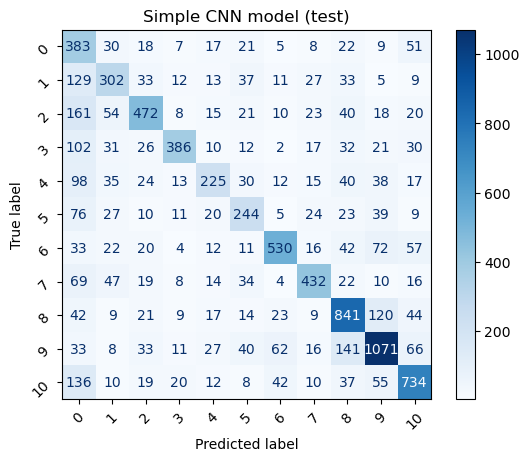

In [86]:
# Collect all predictions and true labels
all_predictions = []
all_true_labels = []

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y2_mapped)

cnn_model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for evaluation
    for inputs, labels in test_loader:

        # Forward pass
        outputs = cnn_model(inputs)

        # Get the predicted class (index of the maximum value in the output)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and true labels
        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)

# Display the confusion matrix
# Invert numeric labels back to bird_names for display
disp_labels = [c.split('/')[0] for c in np.unique(common_labels)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.title('Simple CNN model (test)')

plt.show()